# Evaluation of UNET performance upon common distortions

The aim of this notebook is to provide some informations about how a UNET initially trained to segment cells is perturbated by some common distortions applied on the input images. The tested distortions applied on the inputs are an added 2D gaussian, a gaussian noise as well as a rescaling of the input images. To evaluate the performance of the UNET, several plots are generated: the accuracy, the Jaccard index and the number of detected cells in function of the degree of degradation that depends on the parameters of the distortions.

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# import python libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow

# import distortion filters and utilitary functions
from distortions import add_gaussian, zoom_image, zoom_image_to_meet_shape, add_gaussian_noise
from utils import *
from plots import show_image_mask, show_image_pred, plot_all
from image_processing_methods import dog

### $\bullet$ Setting size of the input image and different paths

In [2]:
# Shape of the inputs of the deep network.
images_shape = (256, 256, 1)

# Variables defining the path to the dataset.
test_input_path = '../Dataset/test/input/'
test_output_path = '../Dataset/test/output/'

# Variable defining where model is stored.
model_save_path = "../Model/"

### $\bullet$ Function to display the input images and predictions upon distorsion as well as a summary of values that shows the quality of the predicted images compared to the ground truth

In [3]:
def evaluation_summary(result, parameter_name, parameter_val, image, mask, distorted_image, model):
    """Eval.
    
    Args:
        images::[np.array]
            The output measures associated to the input measures tX.
        masks::[np.array]
            The input measures.
    
    """
    print("{:<45}: {}".format(parameter_name.upper()          , parameter_val))
    print("{:<45}: {}".format("Accuracy"                      , result["accuracy"]))
    print("{:<45}: {}".format("Jaccard score"                 , result["jaccard"]))
    print("{:<45}: {}".format("Precision"                     , result["precision"]))
    print("{:<45}: {}".format("Recall"                        , result["recall"]))
    print("{:<45}: {}".format("Number of cells in predictions", result["number_cells_predictions"]))
    print("{:<45}: {}".format("Number of cells in masks"      , result["number_cells_masks"]))
    show_image_mask(image, mask)
    show_image_pred(distorted_image, model)
    
    
def evaluate_model(images, masks, model, number_cells_masks=None):
    """Eval.
    
    Args:
        images::[np.array]
            The output measures associated to the input measures tX.
        masks::[np.array]
            The input measures.
    Returns:
        accuracy::[float]
            An array comprised of n_folds equally distributed arrays of y.
        jaccard_score::[float]
            An array comprised of n_folds equally distributed arrays of tX.
        number_cells_predictions::[int]
        number_cells_masks::[int]
    
    """
    predictions = get_binary_predictions(images, model)
    accuracy    = np.mean(predictions == masks)
    jaccard     = compute_jaccard_score(predictions, masks)
    precision, recall = compute_precision_recall(predictions, masks)

    number_cells_predictions = get_number_cells(predictions)
    if number_cells_masks is None:
        number_cells_masks = get_number_cells(masks)
    
    return {"accuracy": accuracy, "jaccard": jaccard, "precision": precision, 
            "recall": recall, "number_cells_predictions": number_cells_predictions,
            "number_cells_masks": number_cells_masks}


def apply_distortion_to_all(function, images, params_for_images={}):
    distorted_images = []
    for image in images:
        distorted_images.append(function(image, **params_for_images))
    
    return np.array(distorted_images)

### $\bullet$ Retrieve trained model

In [4]:
model = tensorflow.keras.models.load_model(model_save_path)

### $\bullet$ Get input images with the wanted shape from dataset

In [5]:
test_images, test_masks = get_dataset_from_folders(test_input_path, test_output_path, images_shape)

print(f'Test set contains {len(test_images)} images of shape {test_images[0].shape}.')

number_cells_masks = get_number_cells(test_masks)
print(f"{number_cells_masks} cells were counted in total over all masks.")

Test set contains 510 images of shape (256, 256, 1).
16410 cells were counted in total over all masks.


In [6]:
from tqdm import tqdm

In [7]:
amplitudes = np.linspace(0, 4000, 10)

all_images = np.zeros((510*10, 256, 256, 1))

for i,amplitude in enumerate(amplitudes):
    all_images[510*i:510*(1+i), :, :, :] = apply_distortion_to_all(add_gaussian, test_images, {"amplitude": amplitude})
    
all_masks = np.repeat(test_masks, 10, axis=0)

In [8]:
sigmas = np.linspace(0.5,0.9,9) 

dist_sigma = []
for sigma in sigmas:
    dist = []
    indeces = np.random.choice(all_images.shape[0], 1000)
    for i in tqdm(indeces):
        dog_added_gaussian_img = dog(all_images[i], sigma)
        dist.append(cv2.norm(all_masks[i]-dog_added_gaussian_img, cv2.NORM_L1))
    
    dist_sigma.append(np.mean(dist))


100%|██████████████████████████████████████| 1000/1000 [01:44<00:00,  9.53it/s]


  0%|                                                    | 0/1 [00:00<?, ?it/s]

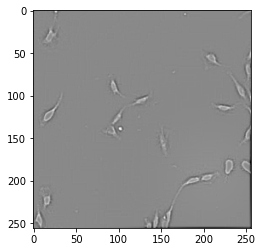

AMPLITUDE BEFORE DOG                         : 4000
Accuracy                                     : 0.9625396728515625
Jaccard score                                : 0.19580065772830763
Precision                                    : 0.2245430809399478
Recall                                       : 0.6046875
Number of cells in predictions               : 31
Number of cells in masks                     : 655


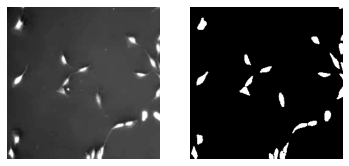

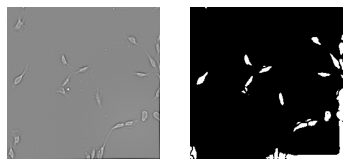

100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


In [53]:
sigma = 0.65
indeces = np.random.choice(all_images.shape[0], 100)
for i in tqdm([-1]):
    dog_added_gaussian_img = dog(all_images[i], sigma)
    #m = np.median(dog_added_gaussian_img)
    #pred = dog_added_gaussian_img >= m
    
    plt.figure()
    plt.imshow(dog_added_gaussian_img, 'gray', vmin=0, vmax=1)
    plt.show()
    
    dog_added_gaussian_img = dog_added_gaussian_img.reshape((1, 256, 256, 1))
    
    result = evaluate_model(dog_added_gaussian_img*256, test_masks[-1], model)
    
    evaluation_summary(result, "Amplitude before DOG", 4000, test_images[-1], test_masks[-1], dog_added_gaussian_img.reshape((256, 256, 1))*256, model)

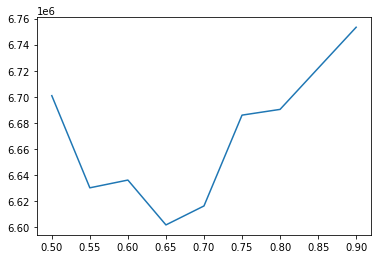

In [9]:
plt.plot(sigmas, dist_sigma)

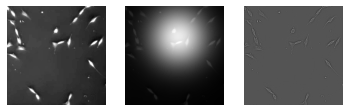

sigma:  0.1
distance:  5831957.924514156


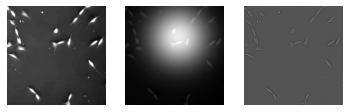

sigma:  0.19473684210526315
distance:  5830688.281147888


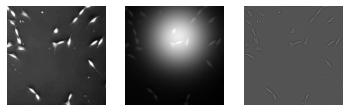

sigma:  0.2894736842105263
distance:  5788133.369077997


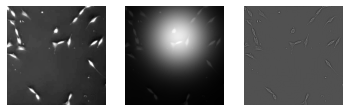

sigma:  0.38421052631578945
distance:  5642850.133215407


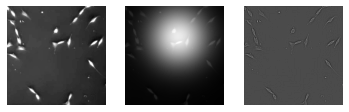

sigma:  0.47894736842105257
distance:  5294924.2658331925


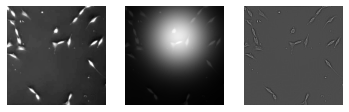

sigma:  0.5736842105263157
distance:  5342414.413305849


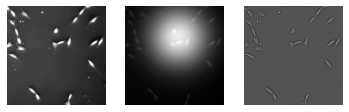

sigma:  0.6684210526315789
distance:  5790723.406129134


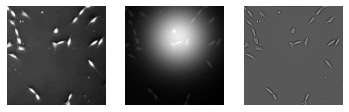

sigma:  0.763157894736842
distance:  6072494.157866807


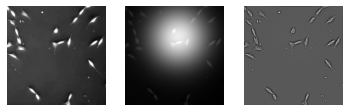

sigma:  0.8578947368421052
distance:  6078418.279123594


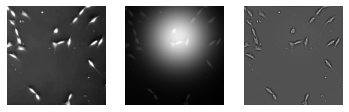

sigma:  0.9526315789473683
distance:  5721866.524178859


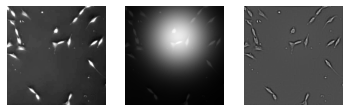

sigma:  1.0473684210526315
distance:  5401184.099311192


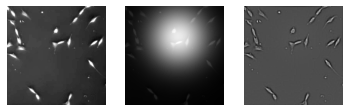

sigma:  1.1421052631578947
distance:  5453009.402246334


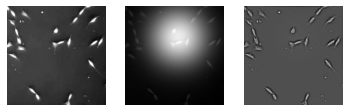

sigma:  1.236842105263158
distance:  5555921.915391656


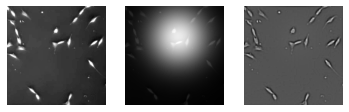

sigma:  1.331578947368421
distance:  5814279.39346766


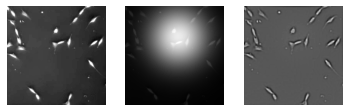

sigma:  1.4263157894736842
distance:  6042187.275656455


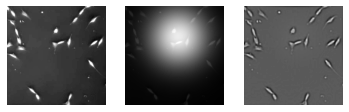

sigma:  1.5210526315789472
distance:  6239186.675566062


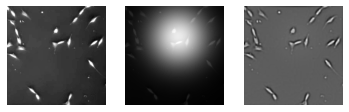

sigma:  1.6157894736842104
distance:  6404967.824264965


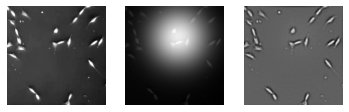

sigma:  1.7105263157894737
distance:  6539705.571076001


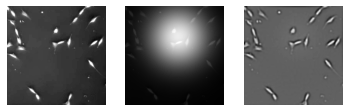

sigma:  1.8052631578947367
distance:  6609678.515291283


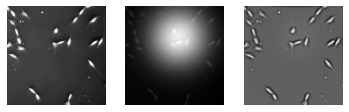

sigma:  1.9
distance:  6552470.334058061


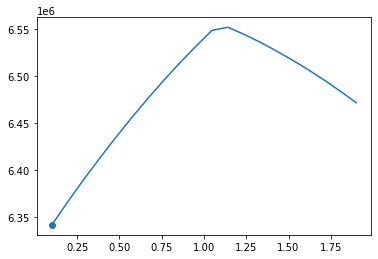

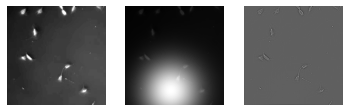

sigma:  0.1
distance:  6384248.22345175


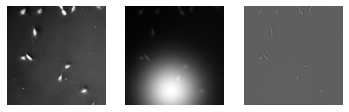

sigma:  0.19473684210526315
distance:  6385164.655224356


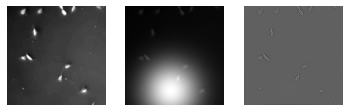

sigma:  0.2894736842105263


KeyboardInterrupt: 

In [38]:
best_dists = []
best_sigmas = []
for img, mask in zip(test_images, test_masks):
    added_gaussian_img = add_gaussian(img, 1000)

    sigmas = np.linspace(0.1,1.9,20)
    distances = []
    for sigma in sigmas:
        fig, axes = plt.subplots(1, 3)
        ax1, ax2, ax3 = axes

        dog_added_gaussian_img = dog(added_gaussian_img, sigma)
        ax1.imshow(img, 'gray')
        ax1.axis('off')
        ax2.imshow(added_gaussian_img, 'gray')
        ax2.axis('off')
        ax3.imshow(dog_added_gaussian_img, 'gray')
        ax3.axis('off')
        plt.show()
        
        distances.append(np.sum(np.abs(mask-dog_added_gaussian_img)))
        print("sigma: ", sigma)
        print("distance: ", np.sum(np.abs(mask-dog_added_gaussian_img)))
        
    best_dist = np.min(distance)
    best_sigma = sigmas[np.argmin(distance)]
    best_dists.append(best_dist)
    best_sigmas.append(best_sigma)
    plt.plot(sigmas, distance)
    plt.scatter(best_sigma, best_dist)
    


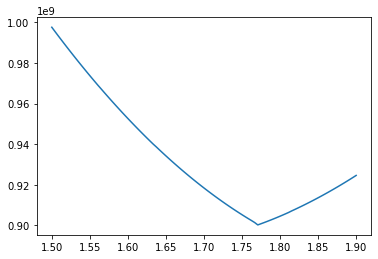

In [30]:
plt.plot(sigmas, distance)